# Homework01 for iannwtf

In [1]:
# imports
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import math

### Data

In [2]:
#Extract the data into (input, target) tuples
data, target = sklearn.datasets.load_digits(return_X_y=True)

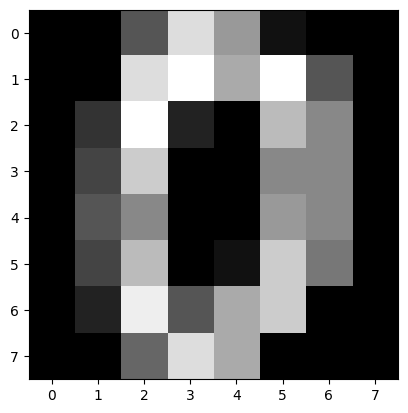

first target digit: 0


In [3]:
# Make sure your input images seem correct by plotting them as images respectively!

# plot the first datapoint 
plt.imshow(data[0].reshape(8,8), cmap="gray")
plt.show()
print("first target digit:", target[0])

In [4]:
#  Reshape the 8x8 images into vectors of shape (64) or (1, 64) depending on your preference
print(data.shape)
print(data[0].shape)

(1797, 64)
(64,)


In [5]:
#  Make sure the images are represented as float32 values within either the
# [0 to 1] or [-1 to 1] range, if necessary rescale them respectively

# normalisieren 
data_normalised = np.array(data / (np.max(data, 1).reshape(data.shape[0], 1)), dtype="float32")

print(data_normalised[0])

# check normalised data
print("Min: 0", np.all(np.min(data_normalised, 1) == 0))
print("Max: 1", np.all(np.max(data_normalised, 1) == 1))
print(type(data_normalised[0]))
print(data_normalised.dtype)

[0.         0.         0.33333334 0.8666667  0.6        0.06666667
 0.         0.         0.         0.         0.8666667  1.
 0.6666667  1.         0.33333334 0.         0.         0.2
 1.         0.13333334 0.         0.73333335 0.53333336 0.
 0.         0.26666668 0.8        0.         0.         0.53333336
 0.53333336 0.         0.         0.33333334 0.53333336 0.
 0.         0.6        0.53333336 0.         0.         0.26666668
 0.73333335 0.         0.06666667 0.8        0.46666667 0.
 0.         0.13333334 0.93333334 0.33333334 0.6666667  0.8
 0.         0.         0.         0.         0.4        0.8666667
 0.6666667  0.         0.         0.        ]
Min: 0 True
Max: 1 True
<class 'numpy.ndarray'>
float32


In [6]:
# One-hot encode the target digits 
# (e.g. the target digit 2 would be represented as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 9 as [0, 0, 0, 0, 0, 0, 0, 0, 0, 9]). 
# Onehot encoded vectors should have the shape (10) or (1, 10) up to your preference

print(target)
nb_classes = 10
one_hot_targets = np.eye(nb_classes)[target]
print(one_hot_targets.shape)
print(one_hot_targets[0], target[0])

[0 1 2 ... 8 9 8]
(1797, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0


In [7]:
# Write a generator function, which shuffles the (input, target) pairs (keeping the respective input and target together)

# Adjust your generator function to create minibatches: Combine minibatchsize many inputs into a ndarray of shape minibatch size, 64, 
# and targets into a ndarray of shape minibatch size, 10 respectively. 
# Make sure you can adjust your minibatchsize as an argument to this generator, and also
# that respective (input-target) pairs match with respect to their index in the minibatch

def generate_batch(minibatch:int, data, targets):

    # shuffle data, keep input and target together
    randomized = np.arange(len(data))
    np.random.shuffle(randomized)
    data = data[randomized]
    targets = targets[randomized]

    # get number of resulting batches
    num_batches = math.ceil(len(data) / minibatch)

    # while there is data generate a batch
    while len(data) > 0:

        # generate batch that will have the given size
        if len(data) >= minibatch:
            data_batch = data[:minibatch]
            data = data[minibatch:]
            target_batch = targets[:minibatch]
            targets = targets[minibatch:]

        # generate batch with remaining data, batch will be smaller than given batchsize
        elif len(data) < minibatch:
            data_batch = data
            data = []
            target_batch = targets 
            targets = []
        
        yield data_batch, target_batch
    

### MLP

In [8]:
class SoftmaxActivation():

    def call(input):
        output = (np.e**(input) / np.sum(np.e**(input)))
        return np.array(output)

In [9]:
class SigmoidActivation():
        
    def call(preactivation):
        return 1 / (1 + np.e**(-preactivation))

    # simple derivative of sigmoid nothing more
    def backwards_call(input):
        return SigmoidActivation.call(input) * (1 - SigmoidActivation.call(input))

In [10]:
class CategoricalCrossEntropyLoss():

    # output a loss (single value) for the prediction and given target 
    def call(prediction, target):
        output = - np.sum(target*np.log(prediction))
        return output


    # backwards step taking into account categorical cross entropy loss and softmax derivative
    # delta: prediction - target
    def backwards_call(prediction, target):
        output = prediction - target
        return np.array(output)

In [11]:
class MLP_layer():

    def __init__(self, activation_function, num_units:int, input_size:int, last_layer = False):

        # parameters given through constructor function
        self.activation_function = activation_function
        self.num_units = num_units
        self.input_size = input_size
        self.last_layer = last_layer

        # parameters set when creating object
        self.weights = np.random.normal(loc=0, scale=0.2, size=(self.num_units, self.input_size))
        self.bias = np.zeros((self.num_units, 1)) 

        # set during call of different function on this object
        self.activation = None
        self.activation_prev_layer = None
        self.drive = None

        # just set 
        self.learningrate = 0.01

    def forward_step(self, input):

        # save the input as the activation of the previous layer for this exact object
        self.activation_prev_layer = input
        # save the drive, current weights times the unput plus the bias
        self.drive = self.weights@input + self.bias
        # put drive through activation function of this object/ layer
        self.activation = self.activation_function.call(self.drive)

        return self.activation

    def backward_step(self, layerplusone_deltatimesweights, target):

        # calculate the delta differently for the last/ output layer
        if self.last_layer == True:
            self.delta = CategoricalCrossEntropyLoss.backwards_call(self.activation, target)
            
        else:
            self.delta = np.reshape(layerplusone_deltatimesweights, (layerplusone_deltatimesweights.shape[0],1)) * self.activation_function.backwards_call(self.drive)

        # return this as the previous layers / next layer in backpropagation will need this
        deltatimesweights = np.reshape(self.delta, (self.delta.shape[0])) @ self.weights
        # delta weights, gradient of how much the weights should change
        weight_update = self.delta @ np.reshape(self.activation_prev_layer, (1,self.activation_prev_layer.shape[0]))
        # update weights
        self.weights = self.weights - self.learningrate * weight_update
        # update bias
        self.bias = self.bias - self.learningrate * self.delta

        return deltatimesweights


In [12]:
class MLP():

    def __init__(self, num_layers:int, layer_activations:list,layer_units:list, layer_input_sizes:list):

        # parameters set through constructor parameter list
        self.num_layers = num_layers
        self.layer_activations = layer_activations
        self.layer_units = layer_units
        self.layer_input_sizes = layer_input_sizes

        # create the layer object of this mlp
        layers = []
        for i in range(self.num_layers):

            if i == self.num_layers -1:
                layer = MLP_layer(activation_function = self.layer_activations[i], num_units = self.layer_units[i], input_size = self.layer_input_sizes[i], last_layer=True)
            else:
                layer = MLP_layer(activation_function = self.layer_activations[i], num_units = self.layer_units[i], input_size = self.layer_input_sizes[i])
                
            layers.append(layer)

        # set the layers of this mlp
        self.layers = np.array(layers)



    def forwardpropagation(self, input, target):

        # for every layer in the mlp propagate the given input
        for index, layer in enumerate(self.layers):
            input = MLP_layer.forward_step(layer, input)
        # compute loss at the end and return it
        loss = CategoricalCrossEntropyLoss.call(self.layers[-1].activation, target) 

        return loss
    
    def backpropagation(self, target):

        # reverse list of layers for propagating backwards
        layers_backwards = np.flip(self.layers)
        deltatimesweights = 0 # set to zero, not ideal but is not used the first time anyway

        for layer in layers_backwards:
            deltatimesweights = layer.backward_step(deltatimesweights, target)

In [13]:
# training function, specifying epochs and mlp
# train given mlp for gien epochs and plot the average loss of every epoch at the end
def training(mlp, epochs, data_normalised, one_hot_targets):
    
    loss = []
    for e in range(epochs):
        randomized = np.arange(len(data_normalised))
        np.random.shuffle(randomized)
        data_normalised = data_normalised[randomized]
        one_hot_targets = one_hot_targets[randomized]
        l = []
        for i in range(len(data_normalised)):
            input = np.reshape(data_normalised[i], (64,1))
            target = np.reshape(one_hot_targets[i], (10,1))
            current_loss = mlp.forwardpropagation(input, target)
            l.append(current_loss)
            mlp.backpropagation(target)
        loss.append(np.mean(l))


    plt.plot(np.linspace(1, epochs+1, epochs), loss)
    plt.title("Average loss per Epoch")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

# Testing

In [16]:
activations = [SigmoidActivation,SigmoidActivation,SigmoidActivation,SigmoidActivation,SigmoidActivation,SigmoidActivation, SoftmaxActivation]
num_units = [20,15,10,20,30,15,10]
input_sizes = [64,20,15,10,20,30,15]
num_layers = 7
mlp = MLP(num_layers, activations, num_units, input_sizes)

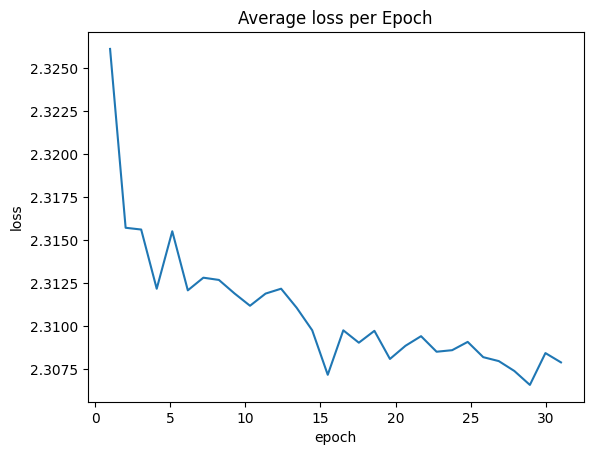

In [17]:
training(mlp, 30, data_normalised, one_hot_targets)